In [39]:
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import polars as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


# Data

In [3]:
subpath = "/home/onyxia/work/data/"
weights = pl.read_parquet(subpath + "weights.parquet")
target = pl.read_parquet(subpath + "target.parquet")
responders = pl.read_parquet(subpath + "responders.parquet")
features = pl.read_parquet(subpath + "features.parquet")

# Architecture

## MLP Buider

In [8]:
def make_mlp(widths, activation=nn.ReLU):
    """
    widths : [in_dim, h1, h2, ..., out_dim]
    """
    layers = []
    for in_f, out_f in zip(widths[:-1], widths[1:]):
        layers.append(nn.Linear(in_f, out_f))
        layers.append(activation())
    layers.pop()  # retire la dernière activation inutile
    return nn.Sequential(*layers)


## Auto-Encoder supervised & unsupervised

In [10]:
class Encoder(nn.Module):
    def __init__(self, widths):
        super().__init__()
        self.net = make_mlp(widths)

    def forward(self, x):
        return self.net(x)


class Decoder(nn.Module):
    def __init__(self, widths):
        super().__init__()
        self.net = make_mlp(widths)

    def forward(self, z):
        return self.net(z)


class TaskHead(nn.Module):
    def __init__(self, widths):
        super().__init__()
        self.net = make_mlp(widths)

    def forward(self, z):
        return self.net(z)


## Build up

In [18]:
class FullModel(nn.Module):
    def __init__(self,
                 encoder_widths,   # ex : [input_dim, 256, 128, latent_dim]
                 decoder_widths,   # ex : [latent_dim, 128, 256, input_dim]
                 head_widths       # ex : [latent_dim, 64, output_dim]
                ):
        super().__init__()

        self.encoder = Encoder(encoder_widths)
        self.decoder = Decoder(decoder_widths)
        self.head = TaskHead(head_widths)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        y_hat = self.head(z)
        return z, x_hat, y_hat


## Utils

In [30]:
def r2_loss(y_true, y_pred):
    """
    R^2 est calculé via sklearn → numpy nécessaire.
    Loss = 1 - R^2 pour pouvoir backpropager.
    """
    y_t = y_true.detach().cpu().numpy()
    y_p = y_pred.detach().cpu().numpy()
    return 1 - r2_score(y_t, y_p)


In [34]:
def train_model(model, X_t, y_t, n_epochs=60, batch_size=64, alpha=1.0, beta=1.0):
    n = len(X_t)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    r2_rec_list = []
    r2_sup_list = []
    loss_list = []

    for epoch in range(n_epochs):
        perm = torch.randperm(n)
        total_loss = 0.0

        for i in range(0, n, batch_size):
            idx = perm[i:i+batch_size]
            xb = X_t[idx]
            yb = y_t[idx]

            z, x_hat, y_hat = model(xb)

            # ---- Loss (MSE) ----
            loss_rec = F.mse_loss(x_hat, xb)
            loss_sup = F.mse_loss(y_hat, yb)

            loss = alpha * loss_rec + beta * loss_sup

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # ---------- R2 pour l'epoch ----------
        with torch.no_grad():
            _, x_hat_full, y_hat_full = model(X_t)

        r2_rec = r2_score(X_t.numpy(), x_hat_full.numpy())
        r2_sup = r2_score(y_t.numpy(), y_hat_full.numpy())

        r2_rec_list.append(r2_rec)
        r2_sup_list.append(r2_sup)
        loss_list.append(total_loss)

        print(f"Epoch {epoch+1:02d} | loss={total_loss:.3f} "
              f"| R2_rec={r2_rec:.4f} | R2_sup={r2_sup:.4f}")

    return r2_rec_list, r2_sup_list, loss_list

In [31]:
def plot_r2(r2_rec_list, r2_sup_list):
    plt.figure(figsize=(10,5))
    plt.plot(r2_rec_list, label="R² reconstruction")
    plt.plot(r2_sup_list, label="R² supervision")
    plt.xlabel("Epoch")
    plt.ylabel("R²")
    plt.title("Évolution du R² pendant l'entraînement")
    plt.legend()
    plt.grid(True)
    plt.show()


# Train simulated data

In [40]:
# Génération données simulées
n = 2000
d = 20

X = np.random.randn(n, d).astype(np.float32)
y = (X[:, :5].sum(axis=1) + 0.1*np.random.randn(n)).astype(np.float32).reshape(-1, 1)

X_t = torch.tensor(X)
y_t = torch.tensor(y)


In [41]:
input_dim = 20
latent_dim = 19
output_dim = 1

model = FullModel(
    encoder_widths=[input_dim, 64, 32, latent_dim],
    decoder_widths=[latent_dim, 32, 64, input_dim],
    head_widths=[latent_dim, 32, output_dim]
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


Epoch 01 | loss=187.290 | R2_rec=0.0094 | R2_sup=0.1255
Epoch 02 | loss=119.873 | R2_rec=0.0542 | R2_sup=0.8457
Epoch 03 | loss=42.978 | R2_rec=0.0789 | R2_sup=0.9650
Epoch 04 | loss=33.370 | R2_rec=0.1113 | R2_sup=0.9827
Epoch 05 | loss=30.148 | R2_rec=0.1423 | R2_sup=0.9895
Epoch 06 | loss=28.529 | R2_rec=0.1768 | R2_sup=0.9915
Epoch 07 | loss=26.888 | R2_rec=0.2247 | R2_sup=0.9930
Epoch 08 | loss=25.199 | R2_rec=0.2656 | R2_sup=0.9939
Epoch 09 | loss=24.002 | R2_rec=0.2925 | R2_sup=0.9941
Epoch 10 | loss=23.145 | R2_rec=0.3168 | R2_sup=0.9945
Epoch 11 | loss=22.403 | R2_rec=0.3384 | R2_sup=0.9946
Epoch 12 | loss=21.534 | R2_rec=0.3675 | R2_sup=0.9955
Epoch 13 | loss=20.436 | R2_rec=0.3990 | R2_sup=0.9959
Epoch 14 | loss=19.297 | R2_rec=0.4301 | R2_sup=0.9960
Epoch 15 | loss=18.517 | R2_rec=0.4558 | R2_sup=0.9960
Epoch 16 | loss=17.758 | R2_rec=0.4735 | R2_sup=0.9941
Epoch 17 | loss=17.281 | R2_rec=0.4856 | R2_sup=0.9960
Epoch 18 | loss=16.881 | R2_rec=0.4935 | R2_sup=0.9959
Epoch 19

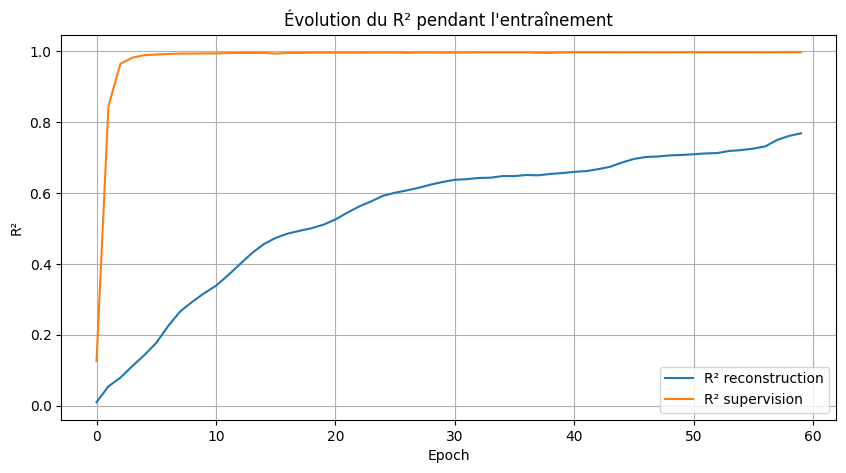

In [42]:
r2_rec_list, r2_sup_list, loss_list = train_model(
    model,
    X_t,
    y_t,
    n_epochs=60,
    batch_size=64,
    alpha=1.0,
    beta=1.0
)

plot_r2(r2_rec_list, r2_sup_list)


# Train real data

In [72]:
# Ajouter un index aux deux DataFrames
features_idx = features.with_row_count("idx")
target_idx   = target.with_row_count("idx")

# Échantillonner seulement sur features
idx_sampled = (
    features_idx
    .sample(fraction=0.1, seed=0)
    .select("idx")
)

# Filtrer features et target sur les mêmes indices
features_sample = features_idx.join(idx_sampled, on="idx").drop("idx")
target_sample   = target_idx.join(idx_sampled, on="idx").drop("idx")

X_t = torch.tensor(features_sample.to_numpy(), dtype=torch.float32)
y_t = torch.tensor(target_sample.to_numpy(), dtype=torch.float32)

/tmp/ipykernel_205032/159476203.py:2: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  features_idx = features.with_row_count("idx")
/tmp/ipykernel_205032/159476203.py:3: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  target_idx   = target.with_row_count("idx")


In [73]:
input_dim = X_t.shape[1]
latent_dim = 10
output_dim = 1

model = FullModel(
    encoder_widths=[input_dim, 64, 32, latent_dim],
    decoder_widths=[latent_dim, 32, 64, input_dim],
    head_widths=[latent_dim, 32, output_dim]
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


Epoch 01 | loss=1474.265 | R2_rec=0.4043 | R2_sup=-0.0047
Epoch 02 | loss=1168.526 | R2_rec=0.4532 | R2_sup=0.0017
Epoch 03 | loss=1113.672 | R2_rec=0.5314 | R2_sup=0.0078
Epoch 04 | loss=1070.654 | R2_rec=0.5618 | R2_sup=0.0021
Epoch 05 | loss=1053.776 | R2_rec=0.5877 | R2_sup=0.0084
Epoch 06 | loss=1033.019 | R2_rec=0.6028 | R2_sup=0.0078
Epoch 07 | loss=1022.422 | R2_rec=0.6128 | R2_sup=0.0098
Epoch 08 | loss=1015.481 | R2_rec=0.6141 | R2_sup=0.0094
Epoch 09 | loss=1012.644 | R2_rec=0.6190 | R2_sup=0.0087
Epoch 10 | loss=1009.358 | R2_rec=0.6181 | R2_sup=0.0114


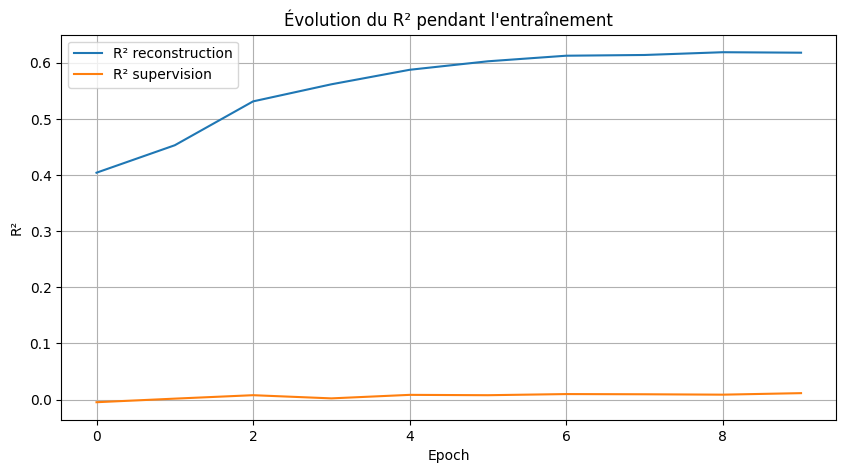

In [75]:
r2_rec_list, r2_sup_list, loss_list = train_model(
    model,
    X_t,
    y_t,
    n_epochs=10,
    batch_size=100,
    alpha=1.0,
    beta=1.0
)

plot_r2(r2_rec_list, r2_sup_list)